In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/task3_dataset.csv'
df = pd.read_csv(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-d0beda4a4b34>:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


In [4]:
# Encode categorical columns
categorical_cols = ['Month', 'Name', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
encoder = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(encoder.fit_transform)

numeric_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly','Monthly_Balance']

# Handling outliers
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Scale numeric columns
def extract_numeric(value):
    if isinstance(value, str):
        value = value.replace('_', '')
        value = value.replace('-', '')
        try:
            return pd.to_numeric(value)
        except ValueError:
            return np.nan
    return value
for col in numeric_cols:
    df[col] = df[col].apply(extract_numeric)
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
#print(df.head(10))

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Merge the numeric and categorical columns and drop the Credit_Score column
X = pd.concat([df[numeric_cols], df[categorical_cols]], axis=1).drop('Credit_Score', axis=1)
y = df['Credit_Score']

# Encode the second column using one-hot encoding
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = ct.fit_transform(X).toarray()

# Select a random subset of the data
subset_indices = np.random.choice(X.shape[0], size=20000, replace=False)
X_subset = X[subset_indices]
y_subset = y[subset_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.25, random_state=42)

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

# Handle missing values
imputer = SimpleImputer(strategy='mean')
row_indices = np.random.randint(0, X_train.shape[0], size=1000)
sample = X_train[row_indices]
imputer.fit(sample)

X_train_imputed = np.empty(X_train.shape)
X_val_imputed = np.empty(X_val.shape)

batch_size = 500
for i in range(0, X_train.shape[0], batch_size):
    X_train_imputed[i:i+batch_size] = imputer.transform(X_train[i:i+batch_size])
    if i < X_val.shape[0]:
        X_val_imputed[i:i+batch_size] = imputer.transform(X_val[i:i+batch_size])


# Apply TruncatedSVD to reduce the dimensionality of the input data
svd = TruncatedSVD(n_components=1000)
X_train_svd = np.empty((X_train_imputed.shape[0], 1000))
X_val_svd = np.empty((X_val_imputed.shape[0], 1000))

batch_size = 1000
for i in range(0, X_train_imputed.shape[0], batch_size):
    X_train_svd[i:i+batch_size] = svd.fit_transform(X_train_imputed[i:i+batch_size])
    if i < X_val_imputed.shape[0]:
        X_val_svd[i:i+batch_size] = svd.transform(X_val_imputed[i:i+batch_size])


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_svd.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(y.nunique(), activation='softmax'))

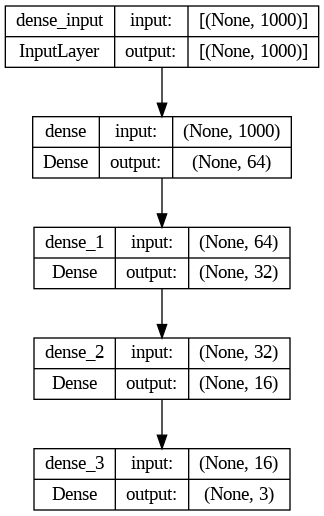

In [9]:
from keras.utils import plot_model
plot_model(model,
           to_file="model.png",
           show_shapes=True,
           show_layer_names=True,
          )

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(X_train_svd, y_train, validation_data=(X_val_svd, y_val), epochs=20, batch_size=64)

Epoch 1/20
235/235 [==============================] - 3s 9ms/step - loss: 27.1083 - accuracy: 0.4112 - val_loss: 5.5964 - val_accuracy: 0.3722
Epoch 2/20
235/235 [==============================] - 2s 7ms/step - loss: 4.1735 - accuracy: 0.4078 - val_loss: 3.1509 - val_accuracy: 0.4480
Epoch 3/20
235/235 [==============================] - 1s 6ms/step - loss: 2.9425 - accuracy: 0.4119 - val_loss: 2.7014 - val_accuracy: 0.3734
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 2.5760 - accuracy: 0.4204 - val_loss: 2.5719 - val_accuracy: 0.3822
Epoch 5/20
235/235 [==============================] - 1s 6ms/step - loss: 2.3047 - accuracy: 0.4175 - val_loss: 2.1974 - val_accuracy: 0.4002
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 2.1554 - accuracy: 0.4197 - val_loss: 2.1251 - val_accuracy: 0.4862
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 1.9886 - accuracy: 0.4298 - val_loss: 2.0336 - val_accuracy: 0.4474
Epoch